<a href="https://colab.research.google.com/github/Connor-NYU/Trading-Agent-RLEA/blob/main/Trading_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
from datetime import datetime
def collect_data(Symbol, start_date, end_date):
    stock_data = yf.Ticker(Symbol)
    return stock_data.history(start=start_date, end=end_date)

#Test the function
df = collect_data('SPY','2020-01-01', '2022-01-01')

In [ ]:
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2020-01-02 00:00:00-05:00,307.254415,308.536468,306.295245,308.517456,59151200,0.0,0.0,0.0
2020-01-03 00:00:00-05:00,304.994224,307.349403,304.937247,306.181305,77709700,0.0,0.0,0.0
2020-01-06 00:00:00-05:00,304.357869,307.434801,304.234408,307.349335,55653900,0.0,0.0,0.0
2020-01-07 00:00:00-05:00,306.760581,307.254425,306.019844,306.485199,40496400,0.0,0.0,0.0
2020-01-08 00:00:00-05:00,306.684650,309.381693,306.428251,308.118652,68296000,0.0,0.0,0.0


In [ ]:
# df_dates = df.index.to_frame().reset_index(drop=True)
df_dates = df.index

In [ ]:
class DeepEvolutionStrategy:

    inputs = None
    
    def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population
    
    def get_weight(self):
        return self.weights

    def train(self, epoch=100, print_every=1):
        last_time = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (w + self.learning_rate / (self.population_size * self.sigma) * np.dot(A.T, rewards).T)

            if (i + 1) % print_every == 0:
                print(f'iter: {i + 1}. reward: {self.reward_function(self.weights)}')
        print(f'time taken to train: {time.time() - last_time} second.')

In [ ]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.input_size = input_size
        self.layer_size = layer_size
        self.output_size = output_size
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights
    
    def set_weights(self, weights):
        self.weights = weights

In [ ]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, money, max_buy, max_sell, close, df_dates, window_size, skip):
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.df_dates = df_dates
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.invest = 0
        self.save_name = time.strftime("%Y-%m-%d-%H-%M-%S") + '-'
        self.es = DeepEvolutionStrategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE
        )

    def get_invest(self):
        return self.invest

    def get_save_name(self):
        return self.save_name

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.close[d : t + 1] if d >= 0 else -d * [self.close[0]] + self.close[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        balance = self.initial_money
        starting_money = balance
        len_close = len(self.close) - 1

        self.model.weights = weights
        state = self.get_state(0)
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and balance >= self.close[t]:
                max_buy = balance // self.close[t]
                if buy < 0:
                    buy = 1
                if buy > max_buy:
                    buy_units = max_buy
                else:
                    buy_units = buy
                total_amount_to_buy = buy_units * self.close[t]
                balance -= total_amount_to_buy
                quantity += buy_units

            elif action == 2 and quantity > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_amount_to_sell = sell_units * self.close[t]
                balance += total_amount_to_sell
            
            state = next_state
        
        profolio_value = balance if quantity == 0 else balance + quantity * self.close[-1]
        return ((profolio_value - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        balance = self.initial_money
        len_close = len(close) - 1
        state = self.get_state(0)
        starting_money = balance
        states_sell = []
        states_buy = []
        inventory = []
        profolio_values = []
        profolio_returns = []
        daily_returns = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and balance >= self.close[t]:
                max_buy = balance // self.close[t]
                if buy < 0:
                    buy = 1
                if buy > max_buy:
                    buy_units = max_buy
                else:
                    buy_units = buy
                total_amount_to_buy = buy_units * self.close[t]
                balance -= total_amount_to_buy
                inventory.append(total_amount_to_buy)
                quantity += buy_units
                states_buy.append(t)
                print(f"day {self.df_dates[t]}: buy {buy_units} units at price {total_amount_to_buy}, total balance {balance}.")
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    profolio_value = balance if quantity == 0 else balance + quantity * self.close[-1]
                    return_rate = round(((profolio_value - starting_money) / starting_money) * 100, 2)
                    if t == 0:
                        previous_profolio_value = starting_money
                    else:
                        previous_profolio_value = profolio_values[-1]
                    daily_returns.append((profolio_value - previous_profolio_value) / previous_profolio_value)
                    profolio_values.append(profolio_value)
                    profolio_returns.append(return_rate)
                    continue
                quantity -= sell_units
                total_amount_to_sell = sell_units * self.close[t]
                balance += total_amount_to_sell
                states_sell.append(t)
                try:
                    invest = ((total_amount_to_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(f"day {self.df_dates[t]}: sell {sell_units} units at price {total_amount_to_sell}, investment {invest}%, total balance {balance}")
            
            state = next_state
            profolio_value = balance if quantity == 0 else balance + quantity * self.close[-1]
            return_rate = round(((profolio_value - starting_money) / starting_money) * 100, 2)
            if t == 0:
                previous_profolio_value = starting_money
            else:
                previous_profolio_value = profolio_values[-1]
            daily_returns.append((profolio_value - previous_profolio_value) / previous_profolio_value)
            profolio_values.append(profolio_value)
            profolio_returns.append(return_rate)

        self.invest = round(((profolio_values[-1] - starting_money) / starting_money) * 100, 2)
        print("\n")
        print(f"total gained {profolio_values[-1] - starting_money}, total_investment {self.invest}%")
        print(f"profolio value: {profolio_values[-1]}, remain stock amount: {quantity}, remain balance: {balance}")

        return starting_money, balance, quantity, profolio_values, profolio_returns, daily_returns, states_buy, states_sell

In [ ]:
input_size = 2
layer_size = 4
output_size = 3
window_size = 30
money = 10000
max_buy = 100
max_sell = 100
close = df['Close'].values.tolist()

weights = [
    np.random.randn(input_size, layer_size),
    np.random.randn(layer_size, output_size),
    np.random.randn(layer_size, 1),
    np.random.randn(1, layer_size),
]

# print("weights: ", weights)
# print(*weights[0].shape)
es = DeepEvolutionStrategy(weights, None, 15, 0.1, 0.003)
# es.train()
model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(
    model = model,
    money = money,
    max_buy = max_buy,
    max_sell = max_sell,
    close = close,
    df_dates = df_dates,
    window_size = window_size,
    skip = 1
)
print(f'Training Market: SPY')
print(f'Training peroid: 2020-01-01 to 2022-01-01')
print(f'Training Market data length: {len(close)}')
print(f"Windows size: {window_size}")
print(f'Training epoch: {500}')
print(f'Initial balance: {money}')
agent.fit(iterations = 500, checkpoint = 100)
# agent.buy()

Training Market: SPY
Training peroid: 2020-01-01 to 2022-01-01
Training Market data length: 505
Windows size: 30
Training epoch: 500
Initial balance: 10000
iter: 100. reward: 286.96661895751953
iter: 200. reward: 339.43542053222654
iter: 300. reward: 405.43778060913087
iter: 400. reward: 406.93916442871097
iter: 500. reward: 413.37168395996093
time taken to train: 153.7776267528534 second.


In [ ]:
df = collect_data('SPY','2020-01-01', '2023-03-31')
close = df['Close'].values.tolist()
df_dates = df.index

agent = Agent(
    model = model,
    money = money,
    max_buy = max_buy,
    max_sell = max_sell,
    close = close,
    df_dates = df_dates,
    window_size = window_size,
    skip = 1
)
starting_money, balance, quantity, profolio_values, profolio_returns, daily_returns, states_buy, states_sell = agent.buy()

day 2020-01-03 00:00:00-05:00: buy 32.0 units at price 9797.7998046875, total balance 202.2001953125.
day 2020-01-06 00:00:00-05:00: sell 32.0 units at price 9835.1806640625, investment 0.381522996184471%, total balance 10037.380859375
day 2020-01-07 00:00:00-05:00: buy 32.0 units at price 9807.5263671875, total balance 229.8544921875.
day 2020-01-09 00:00:00-05:00: sell 32.0 units at price 9926.65234375, investment 1.214638351226393%, total balance 10156.5068359375
day 2020-01-10 00:00:00-05:00: buy 32.0 units at price 9898.0849609375, total balance 258.421875.
day 2020-01-13 00:00:00-05:00: sell 32.0 units at price 9966.1572265625, investment 0.6877316763156225%, total balance 10224.5791015625
day 2020-01-14 00:00:00-05:00: buy 32.0 units at price 9950.9638671875, total balance 273.615234375.
day 2020-01-22 00:00:00-05:00: sell 32.0 units at price 10069.1767578125, investment 1.1879541741157102%, total balance 10342.7919921875
day 2020-01-31 00:00:00-05:00: buy 33.0 units at price 10

In [ ]:
def buy_and_hold_benchmark(df, initial_money):
    dates = df.index
    num_holding = initial_money // df.iloc[0, 3]
    balance_left = initial_money % df.iloc[0, 3]
    buy_and_hold_portfolio_values = df['Close']*num_holding + balance_left
    buy_and_hold_return = buy_and_hold_portfolio_values.iloc[-1] - initial_money
    return dates, buy_and_hold_portfolio_values, buy_and_hold_return

In [ ]:
dates, buy_and_hold_portfolio_values, buy_and_hold_return = buy_and_hold_benchmark(df = df, initial_money = money)

In [ ]:
# len(dates)
len(buy_and_hold_portfolio_values)
len(profolio_values)

770

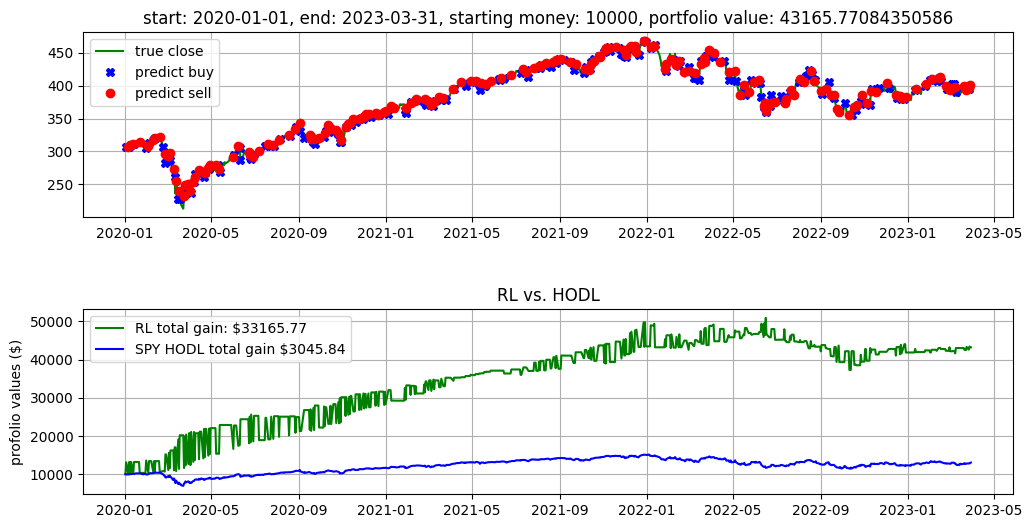

In [ ]:
starting_money, balance, quantity, profolio_values, profolio_returns, daily_returns, states_buy, states_sell
fig, ax = plt.subplots(2, 1, figsize=(12,6), dpi=100)

portfolio_return = profolio_values[-1]
# profolio_values.append(portfolio_return)
ax[0].plot(dates, close, label = 'true close', c = 'g')
ax[0].plot(dates, close, 'X', label = 'predict buy', markevery = states_buy, c = 'b')
ax[0].plot(dates, close, 'o', label = 'predict sell', markevery = states_sell, c = 'r')
ax[0].set_title(f"start: 2020-01-01, end: 2023-03-31, starting money: {money}, portfolio value: {profolio_values[-1]}")
ax[0].legend()
ax[0].grid()

agent_return = profolio_values[-1] - money
ax[1].set_title('{} vs. HODL'.format('RL'))
ax[1].plot(dates, profolio_values, color='green', label='{} total gain: ${:.2f}'.format('RL', agent_return))
ax[1].plot(dates, buy_and_hold_portfolio_values, color='blue', label='{} HODL total gain ${:.2f}'.format('SPY', buy_and_hold_return))
# compare with S&P 500 performance in 2018 if stock is not S&P 500
# if '^GSPC' not in stock_name:
#     dates, GSPC_buy_and_hold_portfolio_values, GSPC_buy_and_hold_return = buy_and_hold_benchmark('^GSPC_2018', agent)
#     ax[1].plot(dates, GSPC_buy_and_hold_portfolio_values, color='red', label='S&P 500 2018 HODL 總收益： ${:.2f}'.format(GSPC_buy_and_hold_return))
ax[1].set_ylabel('profolio values ($)')
# ax[1].set_xticks(np.linspace(0, len(df), 10))
ax[1].legend()
ax[1].grid()

plt.subplots_adjust(hspace=0.5)
# plt.savefig('../output/{}_trading_history.png'.format(stock_name))
plt.show()

In [ ]:
profolio_values.pop()

43165.77084350586

In [ ]:
def maximum_drawdown(portfolio_values):
    end_index = np.argmax(np.maximum.accumulate(portfolio_values) - portfolio_values)
    if end_index == 0:
        return 0
    beginning_iudex = np.argmax(portfolio_values[:end_index])
    return (portfolio_values[end_index] - portfolio_values[beginning_iudex]) / portfolio_values[beginning_iudex]

In [ ]:
import numpy as np
print(f'portfolio value: {profolio_values[-1]}')
print(f'balance: {balance}')
print(f'stock amount: {quantity}')
print(f'portfolio return rate: {profolio_returns[-1]}')
print(f'average daily return: {np.mean(daily_returns) * 100}')
print(f'maximum drawdown: {maximum_drawdown(profolio_values) * 100}')

portfolio value: 43165.77084350586
balance: 40339.87075805664
stock amount: 7.0
portfolio return rate: 331.66
average daily return: 0.9264569717599216
maximum drawdown: -26.75835732076045
